# LGBM을 활용한 베이스라인

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 로딩

data_dir = '/opt/ml/input/data' # 경로는 상황에 맞춰서 수정해주세요!
train_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
test_file_path = os.path.join(data_dir, 'test_data.csv')
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)
df_test = test[test.answerCode!=-1]  # answer_code -1 제외
df_train.shape, df_test.shape

NameError: name 'test' is not defined

## 2. Feature Engineering

In [7]:
day_dict = {'Tuesday': 0,
 'Thursday': 1,
 'Monday': 2,
 'Saturday': 3,
 'Friday': 4,
 'Wednesday': 5,
 'Sunday': 6}

In [3]:
df_train[:2]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225


In [22]:
df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))

0            1
1            1
2            1
3            1
4            1
          ... 
2266581     71
2266582    165
2266583    165
2266584    165
2266585    165
Name: testId, Length: 2266586, dtype: int64

In [5]:
df_train['big_category'] = df_train.testId.map(lambda x:x[2]).astype(int)

0          6
1          6
2          6
3          6
4          6
          ..
2266581    3
2266582    4
2266583    4
2266584    4
2266585    4
Name: testId, Length: 2266586, dtype: int64

In [23]:
def feature_engineering(df):
    df2 = df.copy()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']
    df2['month'] = pd.to_datetime(df2.Timestamp).dt.month
    df2['day'] = pd.to_datetime(df2.Timestamp).dt.day
    df2['hour'] = pd.to_datetime(df2.Timestamp).dt.hour
    df2['dayname'] = pd.to_datetime(df2.Timestamp).dt.day_name().map(day_dict)
    df2['big_category'] = df2.testId.map(lambda x:x[2]).astype(int)
    df2['problem_num'] = df2.assessmentItemID.map(lambda x: int(x[-3:]))
    df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_t.columns = ["test_mean", "test_std", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_std', 'tag_sum']

    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    df2 = pd.merge(df2, correct_k, on=['KnowledgeTag'], how="left")
    
    return df2

train_fe = feature_engineering(df_train)
test_fe = feature_engineering(df_test)
train_fe.shape, test_fe.shape

((2266586, 22), (260114, 22))

In [24]:
train_fe[:2]
test_fe[:2]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,...,dayname,big_category,problem_num,mid_category,test_mean,test_std,test_sum,tag_mean,tag_std,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,3,...,0,6,1,1,0.947683,0.222749,1268,0.955022,0.207410,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,3,...,0,6,2,1,0.947683,0.222749,1268,0.913187,0.281603,3040


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,...,dayname,big_category,problem_num,mid_category,test_mean,test_std,test_sum,tag_mean,tag_std,tag_sum
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,NaN,0,NaN,1,...,1,5,1,23,0.473214,0.5004,106,0.587097,0.493952,91
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1.0,1,1.0,1,...,1,5,2,23,0.473214,0.5004,106,0.587097,0.493952,91


## 3. Train/Test 데이터 셋 분리

### 3.2 train/test Custom 분리

In [25]:
test_to_train = test_fe[test_fe['userID'] == test_fe['userID'].shift(-1)]
test_to_train.shape
train_all = pd.concat([train_fe,test_to_train])
valid = test_fe[test_fe['userID'] != test_fe['userID'].shift(-1)]

# X, y 값 분리
y_train_main = train_all['answerCode']
train_main = train_all.drop(['answerCode'], axis=1)

y_test_main = valid['answerCode']
test_main = valid.drop(['answerCode'], axis=1)

# shape 출력
train_main.shape, test_main.shape

(259370, 22)

((2525956, 21), (744, 21))

### 3.3 CV set train_test split

In [26]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    ## (user_id, 문제푼 횟수)를 원소로 갖는 리스트
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users) # 셔플
    
    max_train_data_len = ratio*len(df) # train data 길이
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users: # for문으로 전체의 ratio 퍼센트만 user_ids에 추가
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)

    ## train, test split
    train = df[df['userID'].isin(user_ids)] # train
    test = df[df['userID'].isin(user_ids) == False] # test

    #test데이터셋은, train에서 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

# 유저별 분리
train, test = custom_train_test_split(train_fe)

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [27]:
train[:2]
test[:2]
train.columns.tolist()

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,day,...,dayname,big_category,problem_num,mid_category,test_mean,test_std,test_sum,tag_mean,tag_std,tag_sum
745,1,A040013001,A040000013,2020-01-06 08:40:43,2048,NaN,0,NaN,1,6,...,2,4,1,13,0.595472,0.490986,789,0.6169,0.486297,971
746,1,A040013002,A040000013,2020-01-06 08:43:46,2048,1.0,1,1.0,1,6,...,2,4,2,13,0.595472,0.490986,789,0.6169,0.486297,971


,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,day,...,dayname,big_category,problem_num,mid_category,test_mean,test_std,test_sum,tag_mean,tag_std,tag_sum
744,0,A080129006,A080000129,2020-12-23 03:40:19,2725,470.0,744,0.631720,12,23,...,5,8,6,129,0.360111,0.480143,780,0.301939,0.459258,436
2786,5,A080138007,A080000138,2020-12-11 22:48:28,8431,662.0,832,0.795673,12,11,...,4,8,7,138,0.504405,0.500118,916,0.491346,0.500166,511


['userID',
 'assessmentItemID',
 'testId',
 'Timestamp',
 'KnowledgeTag',
 'user_correct_answer',
 'user_total_answer',
 'user_acc',
 'month',
 'day',
 'hour',
 'dayname',
 'big_category',
 'problem_num',
 'mid_category',
 'test_mean',
 'test_std',
 'test_sum',
 'tag_mean',
 'tag_std',
 'tag_sum']

# 4. train 데이터만 학습에 모두 사용

In [34]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std', 'tag_std',
         'tag_mean',
         'tag_sum',
        ]

lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. CV 훈련 및 검증

In [50]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=800,
    early_stopping_rounds=100,
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.544612	valid_1's binary_logloss: 0.628726
[200]	training's binary_logloss: 0.539851	valid_1's binary_logloss: 0.626368
[300]	training's binary_logloss: 0.536133	valid_1's binary_logloss: 0.622984
[400]	training's binary_logloss: 0.533025	valid_1's binary_logloss: 0.62273
[500]	training's binary_logloss: 0.529797	valid_1's binary_logloss:

In [29]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100,
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2031
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.559427	valid_1's binary_logloss: 0.681014
[200]	training's binary_logloss: 0.556528	valid_1's binary_logloss: 0.680677
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.558699	valid_1's binary_logloss: 0.680181
VALID AUC : 0.6904581594116477 ACC : 0.6098654708520179



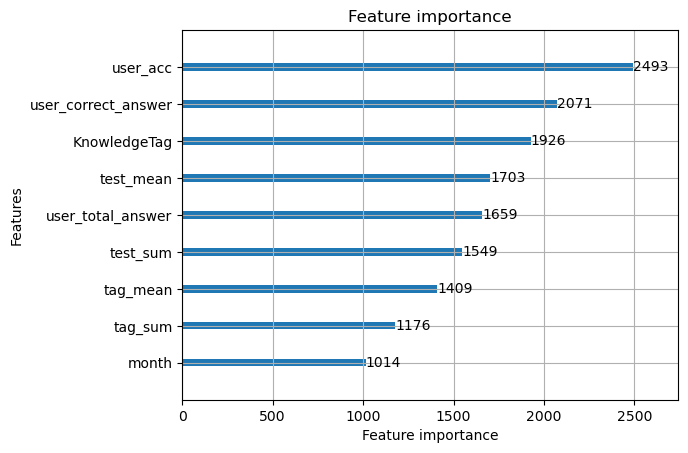

In [21]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. 본 데이터셋으로 학습

In [48]:
train_main.shape, test_main.shape

((2525956, 21), (744, 21))

In [70]:
lgb_train_main = lgb.Dataset(train_main[FEATS], y_train_main)
lgb_test_main = lgb.Dataset(test_main[FEATS], y_test_main)

model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train_main,
    valid_sets=[lgb_test_main],
    verbose_eval=100,
    num_boost_round=500,
#     early_stopping_rounds=200,
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.803649
[200]	valid_0's binary_logloss: 0.812115
[300]	valid_0's binary_logloss: 0.814919
[400]	valid_0's binary_logloss: 0.814489
[500]	valid_0's binary_logloss: 0.813104
VALID AUC : 0.7250327966607035 ACC : 0.661684105630294



In [71]:
lgb_train_main = lgb.Dataset(train_main[FEATS], y_train_main)
lgb_test_main = lgb.Dataset(test_main[FEATS], y_test_main)

model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train_main,
    valid_sets=[lgb_test_main],
    verbose_eval=100,
    num_boost_round=1200,
#     early_stopping_rounds=200,
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.803649
[200]	valid_0's binary_logloss: 0.812115
[300]	valid_0's binary_logloss: 0.814919
[400]	valid_0's binary_logloss: 0.814489
[500]	valid_0's binary_logloss: 0.813104
[600]	valid_0's binary_logloss: 0.811175
[700]	valid_0's binary_logloss: 0.813467
[800]	valid_0's binary_logloss: 0.813273
[900]	valid_0's binary_logloss: 0.81649
[1000]	valid_0's binary_logloss: 0.818124
[1100]	valid_0's binary_lo

In [72]:
lgb_train_main = lgb.Dataset(train_main[FEATS], y_train_main)
lgb_test_main = lgb.Dataset(test_main[FEATS], y_test_main)

model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train_main,
    valid_sets=[lgb_test_main],
    verbose_eval=100,
    num_boost_round=1600,
#     early_stopping_rounds=200,
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.803649
[200]	valid_0's binary_logloss: 0.812115
[300]	valid_0's binary_logloss: 0.814919
[400]	valid_0's binary_logloss: 0.814489
[500]	valid_0's binary_logloss: 0.813104
[600]	valid_0's binary_logloss: 0.811175
[700]	valid_0's binary_logloss: 0.813467
[800]	valid_0's binary_logloss: 0.813273
[900]	valid_0's binary_logloss: 0.81649
[1000]	valid_0's binary_logloss: 0.818124
[1100]	valid_0's binary_lo

In [73]:
lgb_train_main = lgb.Dataset(train_main[FEATS], y_train_main)
lgb_test_main = lgb.Dataset(test_main[FEATS], y_test_main)

model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train_main,
    valid_sets=[lgb_test_main],
    verbose_eval=100,
    num_boost_round=2200,
#     early_stopping_rounds=200,
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.803649
[200]	valid_0's binary_logloss: 0.812115
[300]	valid_0's binary_logloss: 0.814919
[400]	valid_0's binary_logloss: 0.814489
[500]	valid_0's binary_logloss: 0.813104
[600]	valid_0's binary_logloss: 0.811175
[700]	valid_0's binary_logloss: 0.813467
[800]	valid_0's binary_logloss: 0.813273
[900]	valid_0's binary_logloss: 0.81649
[1000]	valid_0's binary_logloss: 0.818124
[1100]	valid_0's binary_lo

In [74]:
lgb_train_main = lgb.Dataset(train_main[FEATS], y_train_main)
lgb_test_main = lgb.Dataset(test_main[FEATS], y_test_main)

model2 = lgb.train(
    {'objective': 'binary'}, 
    lgb_train_main,
    valid_sets=[lgb_test_main],
    verbose_eval=100,
    num_boost_round=3200,
#     early_stopping_rounds=200,
)

preds = model2.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.803649
[200]	valid_0's binary_logloss: 0.812115
[300]	valid_0's binary_logloss: 0.814919
[400]	valid_0's binary_logloss: 0.814489
[500]	valid_0's binary_logloss: 0.813104
[600]	valid_0's binary_logloss: 0.811175
[700]	valid_0's binary_logloss: 0.813467
[800]	valid_0's binary_logloss: 0.813273
[900]	valid_0's binary_logloss: 0.81649
[1000]	valid_0's binary_logloss: 0.818124
[1100]	valid_0's binary_lo

In [75]:
lgb_train_main = lgb.Dataset(train_main[FEATS], y_train_main)
lgb_test_main = lgb.Dataset(test_main[FEATS], y_test_main)

model3 = lgb.train(
    {'objective': 'binary'}, 
    lgb_train_main,
    valid_sets=[lgb_test_main],
    verbose_eval=100,
    num_boost_round=5000,
#     early_stopping_rounds=200,
)

preds = model3.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.803649
[200]	valid_0's binary_logloss: 0.812115
[300]	valid_0's binary_logloss: 0.814919
[400]	valid_0's binary_logloss: 0.814489
[500]	valid_0's binary_logloss: 0.813104
[600]	valid_0's binary_logloss: 0.811175
[700]	valid_0's binary_logloss: 0.813467
[800]	valid_0's binary_logloss: 0.813273
[900]	valid_0's binary_logloss: 0.81649
[1000]	valid_0's binary_logloss: 0.818124
[1100]	valid_0's binary_lo

In [76]:
lgb_train_main = lgb.Dataset(train_main[FEATS], y_train_main)
lgb_test_main = lgb.Dataset(test_main[FEATS], y_test_main)

model3 = lgb.train(
    {'objective': 'binary'}, 
    lgb_train_main,
    valid_sets=[lgb_test_main],
    verbose_eval=100,
    num_boost_round=8200,
#     early_stopping_rounds=200,
)

preds = model3.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.803649
[200]	valid_0's binary_logloss: 0.812115
[300]	valid_0's binary_logloss: 0.814919
[400]	valid_0's binary_logloss: 0.814489
[500]	valid_0's binary_logloss: 0.813104
[600]	valid_0's binary_logloss: 0.811175
[700]	valid_0's binary_logloss: 0.813467
[800]	valid_0's binary_logloss: 0.813273
[900]	valid_0's binary_logloss: 0.81649
[1000]	valid_0's binary_logloss: 0.818124
[1100]	valid_0's binary_lo

In [79]:
lgb_train_main = lgb.Dataset(train_main[FEATS], y_train_main)
lgb_test_main = lgb.Dataset(test_main[FEATS], y_test_main)

model4 = lgb.train(
    {'objective': 'binary'}, 
    lgb_train_main,
    valid_sets=[lgb_test_main],
    verbose_eval=100,
    num_boost_round=16400,
#     early_stopping_rounds=200,
)

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.803649
[200]	valid_0's binary_logloss: 0.812115
[300]	valid_0's binary_logloss: 0.814919
[400]	valid_0's binary_logloss: 0.814489
[500]	valid_0's binary_logloss: 0.813104
[600]	valid_0's binary_logloss: 0.811175
[700]	valid_0's binary_logloss: 0.813467
[800]	valid_0's binary_logloss: 0.813273
[900]	valid_0's binary_logloss: 0.81649
[1000]	valid_0's binary_logloss: 0.818124
[1100]	valid_0's binary_lo

In [80]:
preds = model4.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

VALID AUC : 0.8723881932021466 ACC : 0.7807673143996013



In [ ]:
lgb_train_main = lgb.Dataset(train_main[FEATS], y_train_main)
lgb_test_main = lgb.Dataset(test_main[FEATS], y_test_main)

model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train_main,
    valid_sets=[lgb_test_main],
    verbose_eval=100,
    num_boost_round=1200,
#     early_stopping_rounds=200,
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

## 6. Inference

In [78]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

test_df[:3]

# MAKE PREDICTION
total_preds = model3.predict(test_df[FEATS])

# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission_lgbm_add_time_test_tag_std_big_mid_problem_number_8200epoch_valauc_8220.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,day,...,dayname,big_category,problem_num,mid_category,test_mean,test_std,test_sum,tag_mean,tag_std,tag_sum
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,717.0,1035,0.692754,10,26,...,2,5,8,133,0.661765,0.490209,90,0.542662,0.505845,159
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,465.0,670,0.694030,12,27,...,6,7,8,146,0.740385,0.539601,77,0.565693,0.552442,155
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,915.0,1316,0.695289,12,27,...,6,7,8,111,0.417857,0.501291,117,0.446753,0.518307,172


writing prediction : output/submission_lgbm_add_time_test_tag_std_big_mid_problem_number_8200epoch_valauc_8220.csv


14

21

21

21

21

22

19

22

21

22

21

22

23

22

22

22

22

23

22

22

23

22

22

22

23

22

22

22

22

22

22

22

22

23

21

22

22

23

23

23

23

23

23

22

22

22

22

22

23

22

22

22

22

22

23

22

22

23

22

23

23

22

22

22

23

23

21

22

22

22

22

22

22

23

22

22

21

23

22

23

22

22

22

22

22

22

22

22

23

22

23

23

24

23

21

22

22

23

22

22

21

22

23

23

23

23

23

22

23

24

23

23

23

24

24

24

23

23

24

24

24

23

23

23

24

25

24

23

24

23

24

23

23

23

24

23

23

22

22

23

23

23

23

24

23

23

23

23

23

24

23

24

23

23

24

23

22

24

23

23

23

23

23

23

23

23

23

24

23

23

23

23

23

24

24

24

22

23

23

24

24

24

24

24

23

23

23

24

23

23

24

23

23

24

23

23

23

23

22

23

23

23

22

22

22

23

23

24

24

24

24

23

24

24

22

22

22

23

22

23

23

23

23

23

23

23

23

22

23

23

24

24

23

23

24

23

23

24

24

24

23

22

22

23

23

23

23

24

22

24

24

22

22

23

23

23

23

23

23

24

22

23

23

23

24

24

23

23

23

23

23

24

24

24

23

22

23

23

24

21

23

23

24

23

23

23

24

24

24

23

23

23

24

24

23

23

23

22

23

23

24

23

24

22

23

23

24

23

23

23

23

23

23

22

23

23

23

23

23

24

23

22

23

23

24

23

23

23

24

23

23

23

24

23

24

23

22

24

23

23

23

23

23

23

23

23

23

23

24

23

23

23

23

24

23

23

23

23

24

24

23

23

24

24

22

23

23

22

23

24

24

23

23

23

23

24

23

23

24

24

23

24

23

23

24

23

23

23

23

23

23

23

24

22

24

22

23

23

22

23

24

23

22

23

24

24

24

23

23

22

24

23

24

24

24

23

24

23

23

23

24

23

23

23

23

23

25

23

23

23

23

23

23

23

23

23

23

22

24

23

23

24

23

23

23

23

23

24

23

23

23

23

23

23

24

24

23

23

22

23

23

23

23

23

24

22

24

23

23

24

23

24

23

23

22

23

23

23

24

23

23

23

24

24

24

23

24

23

24

24

24

24

22

23

23

23

23

24

23

24

23

22

24

23

24

23

24

23

23

22

24

22

24

23

23

22

24

23

24

24

24

23

23

23

24

23

24

23

23

23

23

23

24

24

22

24

23

23

24

24

24

23

23

23

23

23

23

23

23

23

23

23

22

23

23

24

23

24

23

23

23

23

23

23

23

23

23

25

23

23

23

24

23

24

24

24

23

24

23

23

23

23

23

23

23

24

23

23

23

23

23

24

23

23

23

23

23

23

23

23

24

23

23

23

23

23

23

24

22

23

23

23

24

23

24

23

23

23

24

24

23

24

24

24

24

23

23

23

23

24

23

23

22

23

24

23

24

23

23

23

23

23

24

22

23

23

24

23

23

23

23

24

23

23

23

24

23

22

23

23

23

22

22

22

23

23

23

23

23

24

23

22

25

23

23

24

23

25

23

22

23

24

23

23

23

23

23

24

23

23

23

23

24

23

24

23

24

23

24

24

23

22

23

23

23

24

24

24

22

23

24

23

24

23

23

23

23

23

23

23

22

23

23

23

22

23

23

24

24

23

23

23

23

24

23

23

23

23

23

23

23

23

23

23

23